# Starbucks Promotional Offers Data Project (Modelling Notebook)

In [1]:
# Import Python data modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import other functions
from sqlalchemy import create_engine

# Import modelling functions
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, make_scorer, silhouette_score
import imblearn.over_sampling

# Feature engineering objects and functions
from sklearn.manifold import TSNE

# Clustering objects
from sklearn.cluster import KMeans

## Data Import and Preperation

In [2]:
# Create a connection to the MySQL database
user = 'root'
hidden = 'Basketba11isgood' 
host = 'localhost'
port = '3306'
database = 'starbucks_promotions_db'

connection = create_engine(f'mysql+mysqlconnector://{user}:{hidden}@{host}:{port}/{database}')

# Read in data from the SQL Database
offers = pd.read_sql('SELECT * FROM offers', con=connection)
customers = pd.read_sql('SELECT * FROM customers', con=connection)
transactions = pd.read_sql('SELECT * FROM transactions', con=connection)
offers_received = pd.read_sql('SELECT * FROM offers_received', con=connection)
offers_viewed = pd.read_sql('SELECT * FROM offers_viewed', con=connection)
offers_completed = pd.read_sql('SELECT * FROM offers_completed', con=connection)

In [3]:
# Check the primary table that will be used for modelling
customers.head(3)

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,None,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,None,NaN,NaN


The model will try to predict whether customers will complete any offer. Since the `customers` table has a row per customer, this table is at the correct granularity. The missing values in the `gender`, `age`, and `income` values will also need to be dealt with. However, this should be done after splitting the data

In [4]:
# Bin the became_member_on column by extracting just the year
customers['became_member_on_year'] = customers['became_member_on'].dt.year

### Defining a Target

In [5]:
# Create a DataFrame that says how many times each customer completed an offer sent to them
num_completed = (offers_completed.groupby('customer_id')[['offer_id']]
                                 .count()
                                 .rename({'offer_id': 'num_completed'}, axis=1)
                                 .reset_index()
                )

# Add the num_completed column to the customers table by merging the two DataFrames
customers = customers.merge(num_completed, how='left', on='customer_id')

# Change the num_completed column to be binary (1 if customer completed an offer, 0 if not)
customers['num_completed'] = np.where(customers['num_completed'] > 0, 0, 1)

# Rename the column to represent this change
customers = customers.rename({'num_completed': 'completed'}, axis=1)

In [6]:
customers['completed'].value_counts()

completed
0    12774
1     4226
Name: count, dtype: int64

In [7]:
# Check the target (completed column) distribution to see if there are any imbalances
customers['completed'].value_counts(normalize=True)

completed
0    0.751412
1    0.248588
Name: proportion, dtype: float64

The target is unbalanced. May need to use balancing methods

## Exploratory Data Analysis

### Exploring the Features

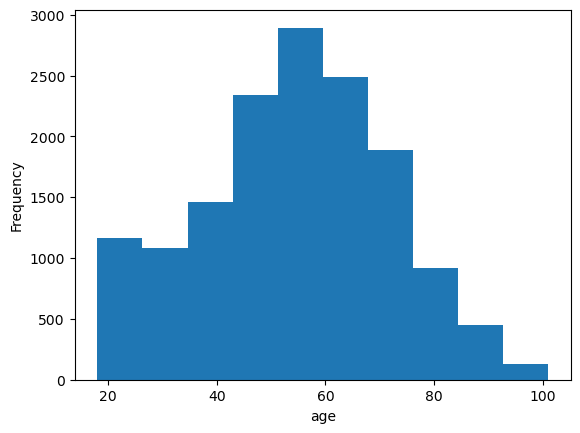

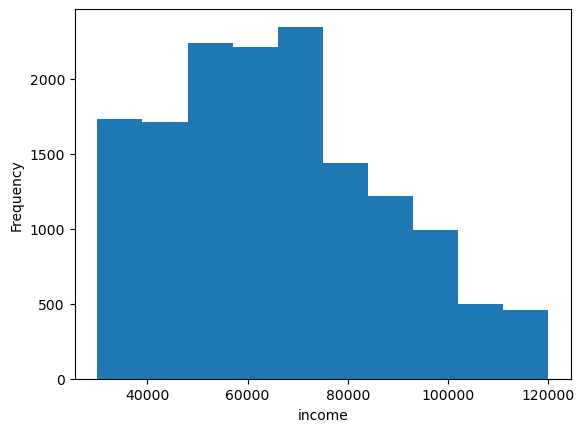

In [8]:
# See the distribution of each numeric feature by plotting histograms
for column in ['age', 'income']:
    customers[column].plot.hist()
    plt.xlabel(column)
    plt.show()

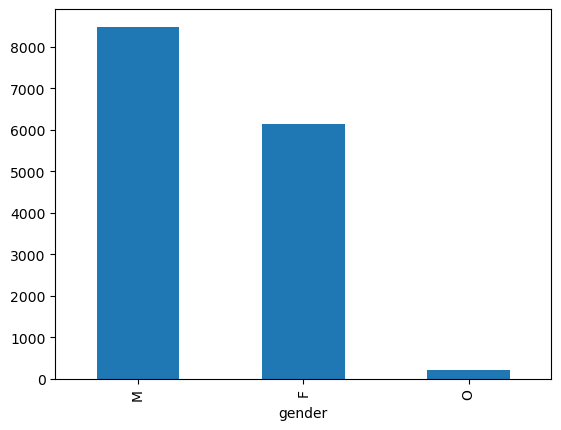

In [9]:
# See the distribution of each categorical feature by plotting bar charts
customers['gender'].value_counts().plot.bar()
plt.show()

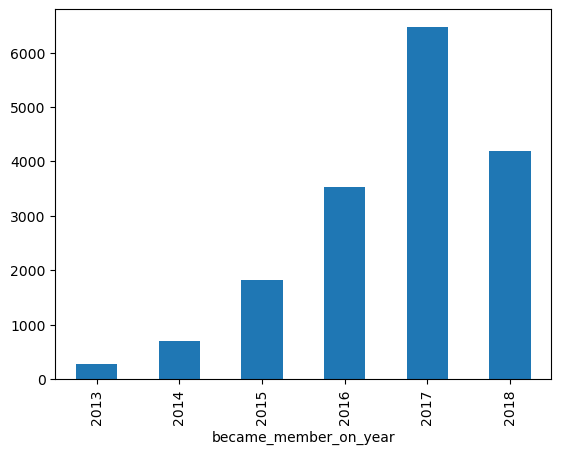

In [10]:
customers['became_member_on_year'].value_counts().sort_index().plot.bar()
plt.show()

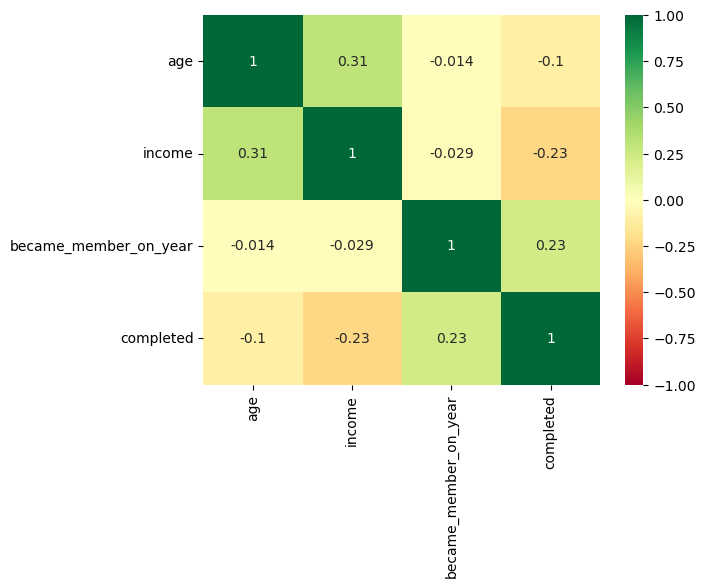

In [11]:
# Explore the correlation of the numeric variables
sns.heatmap(
    customers.corr(numeric_only=True), 
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='RdYlGn'
);

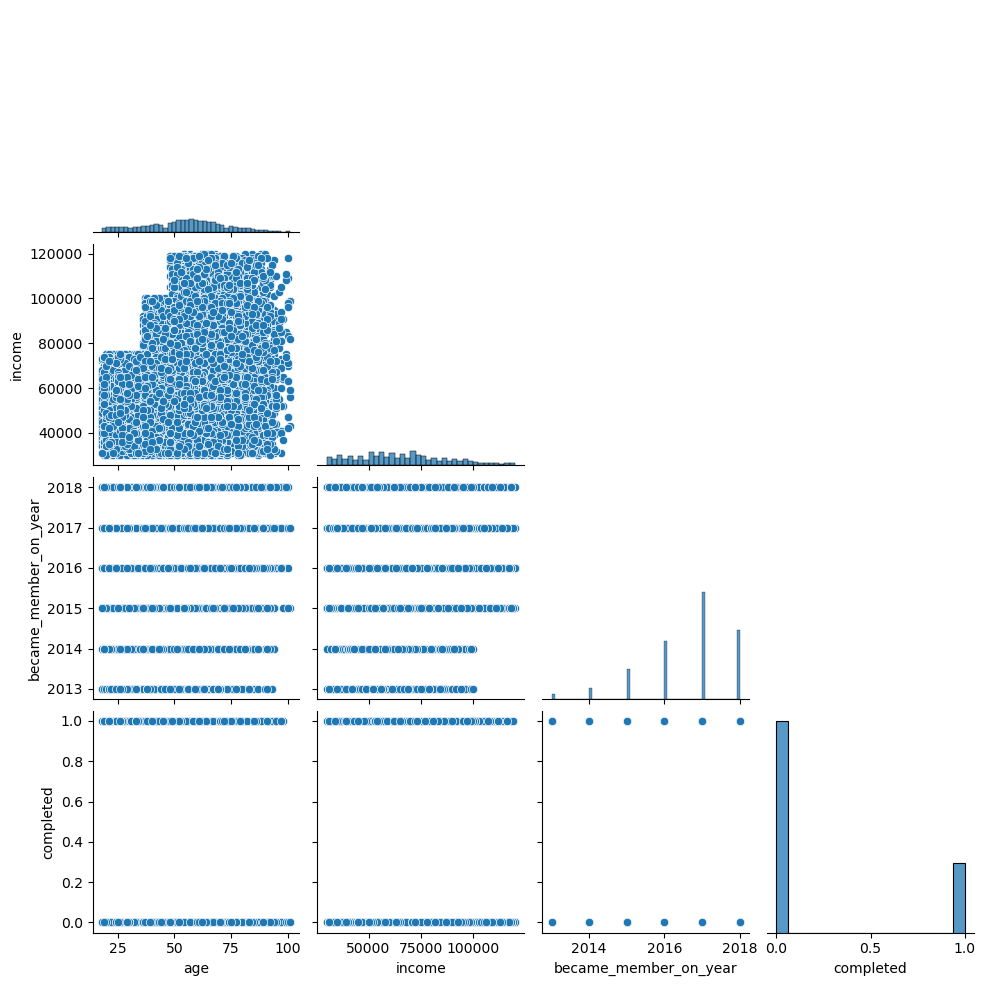

In [12]:
# Look at the relationships between the numeric variables
sns.pairplot(customers, corner=True);

### Explore Feature-Target Relationships

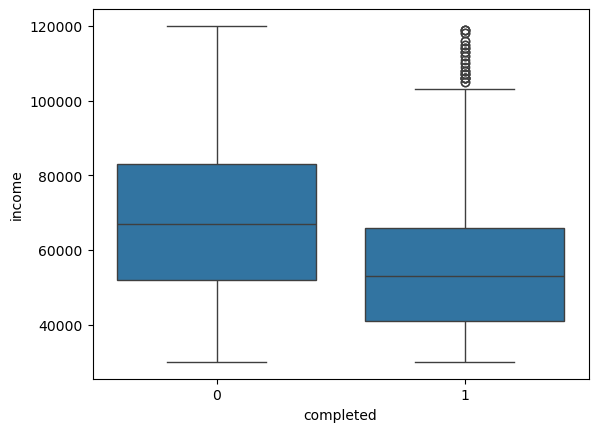

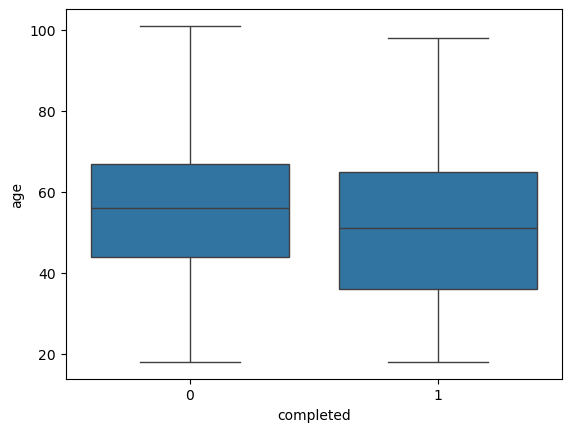

In [13]:
for column in ['income', 'age']:  #.select_dtypes(include='number').drop(['completed', 'missing'], axis=1):
    sns.boxplot(customers, x='completed', y=column)
    plt.show()

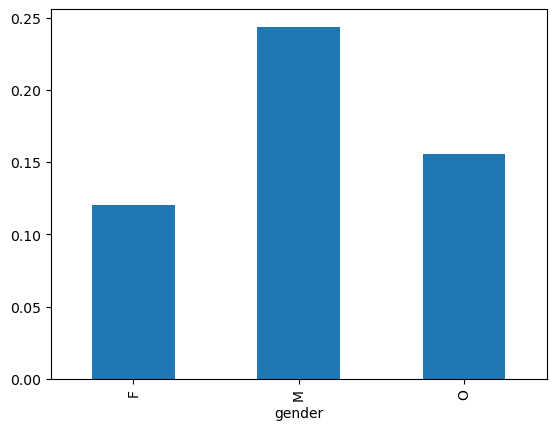

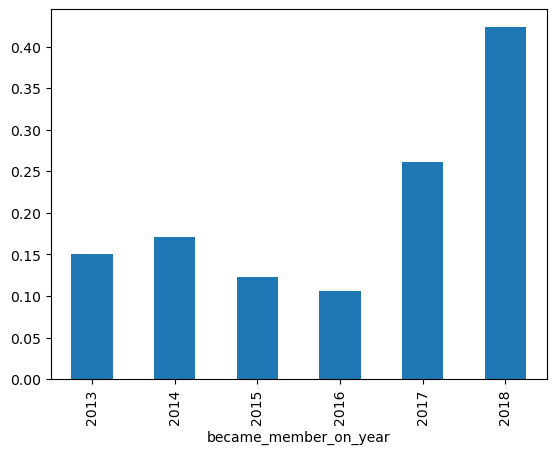

In [14]:
for column in ['gender', 'became_member_on_year']:
    customers.groupby(column)['completed'].mean().plot.bar()
    plt.show()

## Modelling Preperation

### Train & Test Data Splitting

In [15]:
# Create a copy of the customers DataFrame so we can easily go back and look at the base customers table if needed
model = customers.copy()

In [16]:
# Split the data into a train and test set before model prep to ensure unbiased testing
X = model.drop('completed', axis=1)
y = model['completed']

X_temp, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    train_size=0.9,
    test_size=0.1,
    random_state=42, 
    stratify=y
)

### Cleaning for Modelling

Need to deal with the missing values for `income`, `age`, and `gender` columns

In [17]:
# Fill in the missing values with the median for the age and income columns
for column in ['age', 'income']:
    X_temp[column] = X_temp[column].fillna(X_temp[column].median())

In [18]:
# Check the distribution of gender values
X_temp['gender'].value_counts(normalize=True, dropna=False)

gender
M       0.496797
F       0.362614
None    0.127451
O       0.013137
Name: proportion, dtype: float64

In [19]:
# Add a 'Missing' value for None values
X_temp['gender'] = X_temp['gender'].fillna('Missing')

In [20]:
# Turn the categorical variables (just gender in this case) into dummy variables
X_temp = pd.get_dummies(
    X_temp,
    columns=['gender'],
    drop_first=True,
    dtype='int'
)

In [21]:
# Check the modelling DataFrame
X_temp.head()

,customer_id,became_member_on,age,income,became_member_on_year,gender_M,gender_Missing,gender_O
2350,8ead309bb7254edbab114c8837cd54b2,2017-09-26,42.0,63000.0,2017,0,0,1
6962,d3087275deda496ca72179083b513392,2017-11-20,47.0,53000.0,2017,0,0,0
4332,ffede3b700ac41d6a266fa1ba74b4f16,2018-07-04,55.0,64000.0,2018,0,1,0
5699,131acac3f21b430bb6c0df9fa77b4b08,2017-10-10,80.0,74000.0,2017,0,0,0
11232,7ea422e760d54a41be4030be27bc1d62,2017-05-03,35.0,66000.0,2017,0,0,0


### Feature Engineering

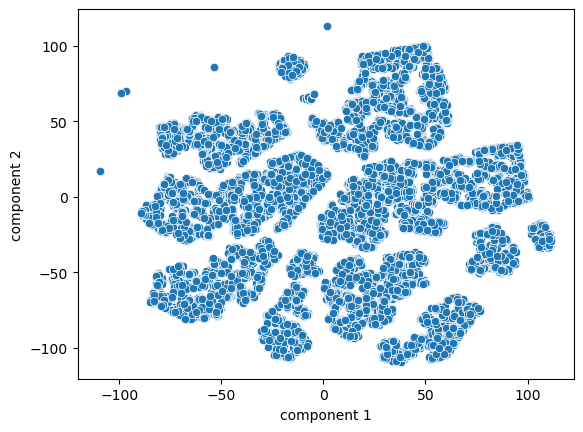

In [22]:
# Build a t-SNE visualisation to see if there are any potential clusters in the data for a possible engineered feature
# Select the numeric columns of the data ('became_member_on_year', 'age', 'income', 'gender_M', 'gender_Missing', 'gender_O')
tsne_data = X_temp.iloc[:, 2:]

# Standardise the data
std_tsne = StandardScaler()
cluster_data = std_tsne.fit_transform(tsne_data)

# Create a t-SNE object 
tsne = TSNE(n_components=2, random_state=42)

# Fit a t-SNE model on the standardised data and transform the data into a lower dimensionality space
data_tsne = tsne.fit_transform(cluster_data)
data_tsne = pd.DataFrame(data_tsne, columns=['component 1', 'component 2'])

# Plot the t-SNE data
sns.scatterplot(
    data=data_tsne,
    x='component 1',
    y='component 2'
);

In [23]:
# Create a KMeans cluster since there seems to be around 13 clusters in the t-SNE visualisation
# Create a KMeans object with 13 clusters
kmeans13 = KMeans(
    n_clusters=13,
    n_init=100,
    random_state=42
)

# Fit the KMeans model on the standardised data
kmeans13.fit(cluster_data)

# Add the clusters to the tsne results (data_tsne) DataFrame
data_tsne['kmeans13'] = kmeans13.labels_

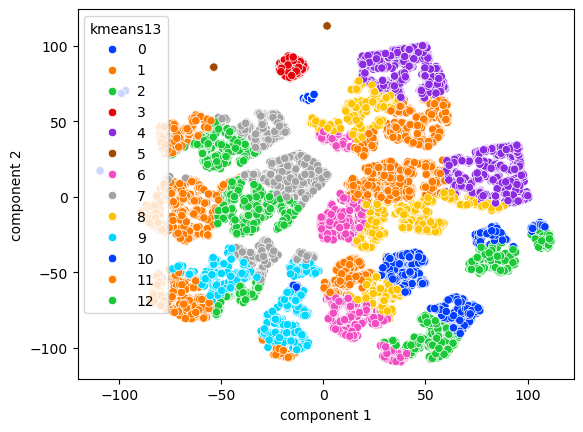

In [24]:
# Plot the t-SNE data with 'kmeans13' as the hue
sns.scatterplot(
    data=data_tsne,
    x='component 1',
    y='component 2',
    hue='kmeans13',
    palette='bright'
);

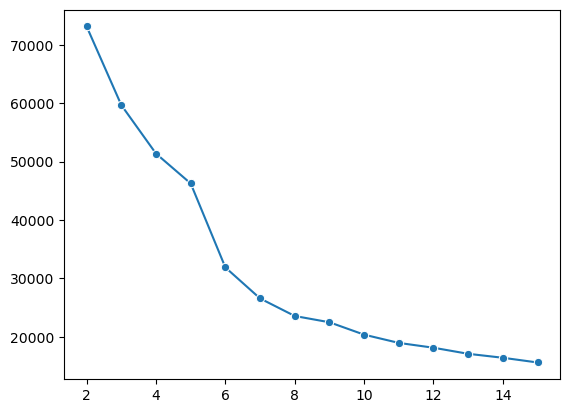

In [25]:
# Since the kmeans13 did not match the t-SNE visualisation clusters, check the inertia values and silhouette scores
# Fit a kmeans model on k between 2 and 15 to see the best inertia score
inertia = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init='auto', verbose=0, random_state=42)
    kmeans.fit(cluster_data)
    inertia.append(kmeans.inertia_)

# Plot the inertia scores
sns.lineplot(pd.Series(inertia, index=range(2, 16)), marker='o');

In [26]:
# Create a KMeans cluster with 6 clusters due to the inertia plot
# Create a KMeans object with 13 clusters
kmeans6 = KMeans(
    n_clusters=6,
    n_init=100,
    random_state=42
)

# Fit the KMeans model on the standardised data
kmeans6.fit(cluster_data)

# Add the clusters to the tsne results (data_tsne) DataFrame
data_tsne['kmeans6'] = kmeans6.labels_

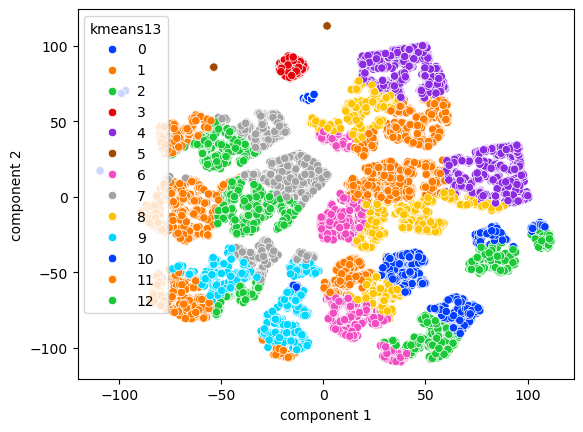

In [27]:
# Plot the t-SNE data with 'kmeans6' as the hue
sns.scatterplot(
    data=data_tsne,
    x='component 1',
    y='component 2',
    hue='kmeans13',
    palette='bright'
);

In [28]:
# Check the silhouette scores of the kmeans13 model and the kmeans6 model
for kmeans in [kmeans13, kmeans6]:
    print(silhouette_score(cluster_data, kmeans.labels_))

0.3272703494722517
0.33070492428425347


In [29]:
# With weak silhouette scores and the lack of a match with the t-SNE visualisation, it would be best to try a diff cluster model

In [30]:
num_received = (offers_received.groupby('customer_id')
                               .count()
                               .reset_index()
                               [['customer_id', 'offer_id']]
                               .rename(
                                   {'offer_id': 'num_received'}, 
                                   axis=1
                               )
               )

X_temp = X_temp.merge(
    num_received,
    how='left',
    on='customer_id'
).fillna(0)

In [31]:
amount = (transactions.groupby('customer_id')[['amount']]
                      .sum()
                      .reset_index())

X_temp = X_temp.merge(
    amount,
    how='left',
    on='customer_id'
).fillna(0)

X_temp['log_amount'] = np.log(X_temp['amount'] + 1e-6).clip(0) 

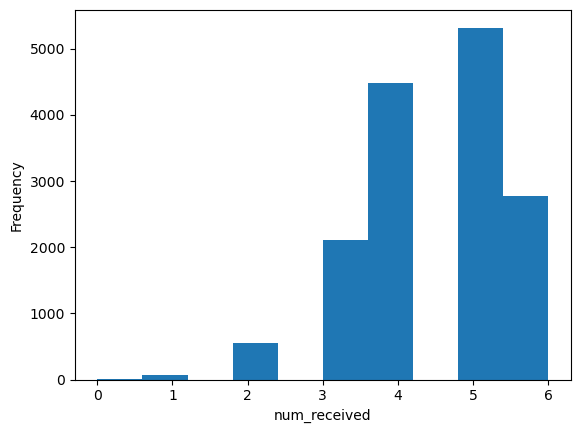

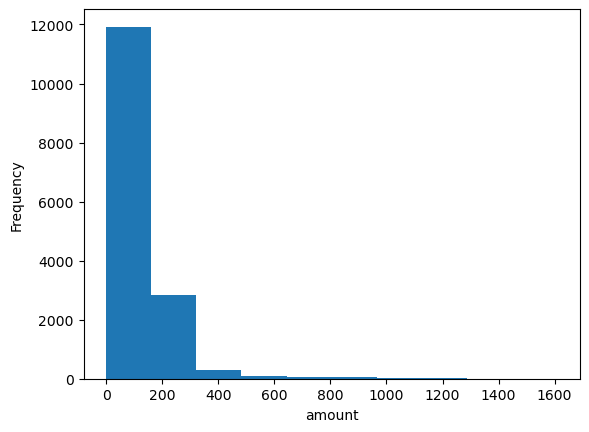

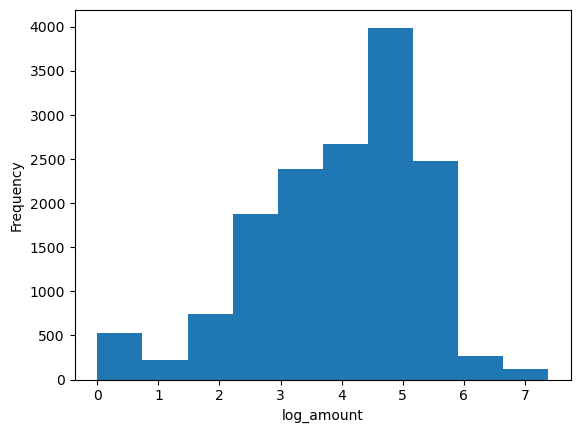

In [32]:
for column in X_temp.loc[:, 'num_received':].select_dtypes(include='number'):
    X_temp[column].plot.hist()
    plt.xlabel(column)
    plt.show()

### Train & Validation Data Splitting

In [33]:
# Make a copy of the target Series
y = y_train.copy()

# Drop the customer identifier column
model = model.drop('customer_id', axis=1)

In [34]:
# Chose the features
X = X_temp[[
        #'became_member_on'
        #'became_member_on_year',
        #'age',
        #'income',
        'gender_M',
        'gender_Missing',
        'gender_O',
        'num_received',
        #'amount',
        'log_amount'
]]

# Split the train data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=2/9,
    random_state=42, 
    stratify=y
)

# Use SMOTE to resample the data to improve predictive accuracy with inbalanced data
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

ratio = {1: int(n_pos * 1.5), 0: n_neg}

smt = imblearn.over_sampling.SMOTE(
    sampling_strategy=ratio,
    random_state=42
)

X_train_rs, y_train_rs = smt.fit_resample(X_train, y_train)

# Create standardised datasets if needed for particular models
std = StandardScaler()
X_train_std = std.fit_transform(X_train_rs)
X_val_std = std.fit_transform(X_val)

## Modelling

In [35]:
def scoring(model, X, y, threshold=0.5):
    """
    Prints out a confusion matrix and ROC curve and prints the accuracy score, precision score, recall score, 
    f1 score, and AUC of a classification model.
    
    Inputs:
        model: Classification model (fitted sklearn Evaluation Object)
        X: Features (pd.DataFrame)
        y: Actual target values for features (pd.Series)

    Returns:
        None
    """
    # Get the predicted values of the model
    predicted_y_values = model.predict_proba(X)[:, 1] >= threshold

    # Build a confusion matrix
    sns.heatmap(
        confusion_matrix(y, predicted_y_values),
        cmap='Blues',
        annot=True,
        fmt='g',
        square=True,
        xticklabels=['None Completed', 'Completed'],
        yticklabels=['None Completed', 'Completed'],
    ).set(
        xlabel='Actual',
        ylabel='Predicted',
        title='Confusion_Matrix'
    )
    plt.show()
    plt.clf()

    # Build an ROC curve with AUC score
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Model (AUC Score: {auc_score:.2f})')
    plt.plot([0,1], [0,1], color='Black', linestyle='--', label='Random Guess (AUC Score: 0.50)')
    plt.xlabel('False Positive Rate'),
    plt.ylabel('True Positive Rate'),
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    plt.clf()

    # Print out scoring metrics
    print(f'Accuracy Score: {accuracy_score(y, predicted_y_values)}')
    print(f'Precision Score: {precision_score(y, predicted_y_values)}')
    print(f'Recall Score: {recall_score(y, predicted_y_values)}')
    print(f'f1 Score: {f1_score(y, predicted_y_values)}')

### K-Nearest Neighbours Model

In [36]:
params = {
    'n_neighbors': range(1, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(
    KNeighborsClassifier(), 
    params,
    scoring=make_scorer(f1_score),
    n_jobs=1,
    cv=5,
    verbose=1
)
grid.fit(X_train_std, y_train_rs)
grid.best_params_

Fitting 5 folds for each of 196 candidates, totalling 980 fits


{'metric': 'euclidean', 'n_neighbors': 45, 'weights': 'uniform'}

In [37]:
knn = KNeighborsClassifier(**grid.best_params_)
knn.fit(X_train_std, y_train_rs)

KNeighborsClassifier(metric='euclidean', n_neighbors=45)

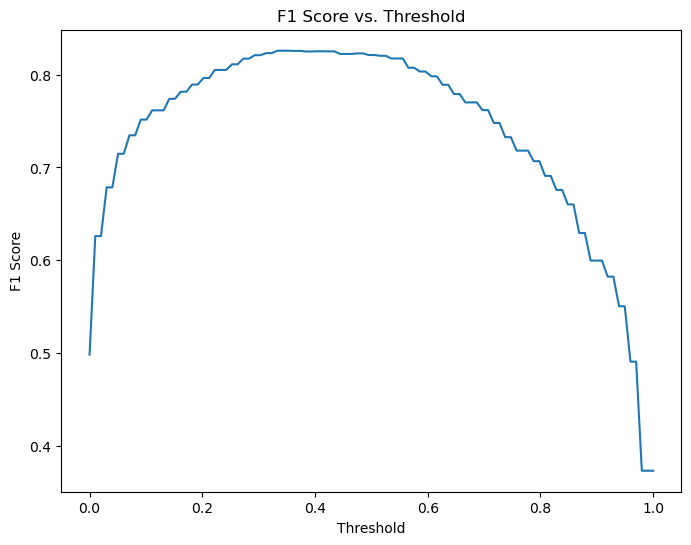

In [38]:
thresholds = np.linspace(0, 1, 100)
f1_scores = []
for threshold in thresholds:
    f1_scores.append(f1_score(y_train_rs, knn.predict_proba(X_train_std)[:, 1] >= threshold))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()

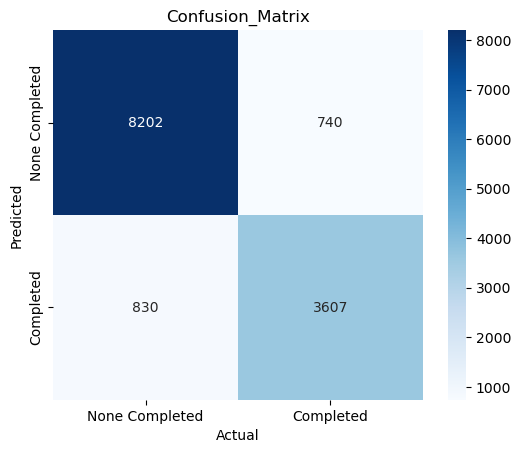

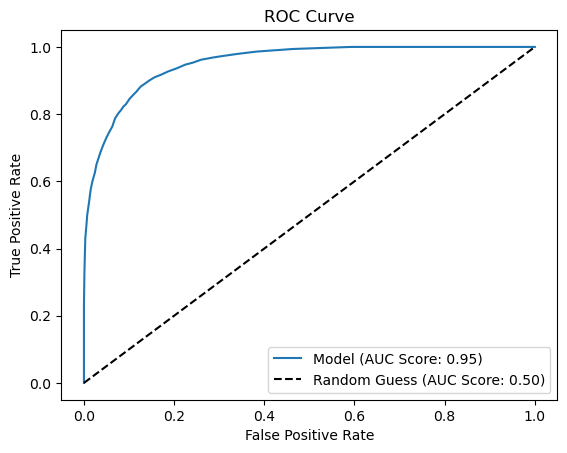

Accuracy Score: 0.882651917183646
Precision Score: 0.8297676558546124
Recall Score: 0.8129366689204417
f1 Score: 0.8212659380692168


<Figure size 640x480 with 0 Axes>

In [39]:
scoring(knn, X_train_std, y_train_rs)

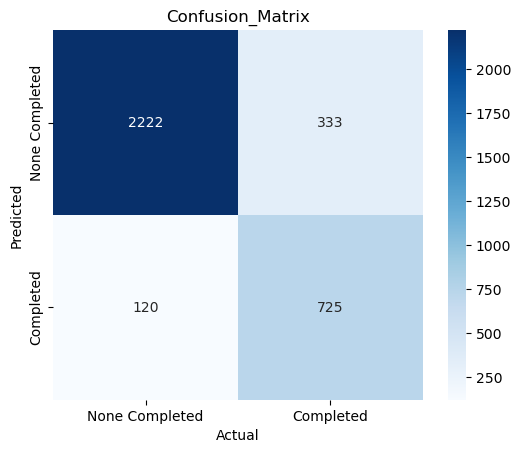

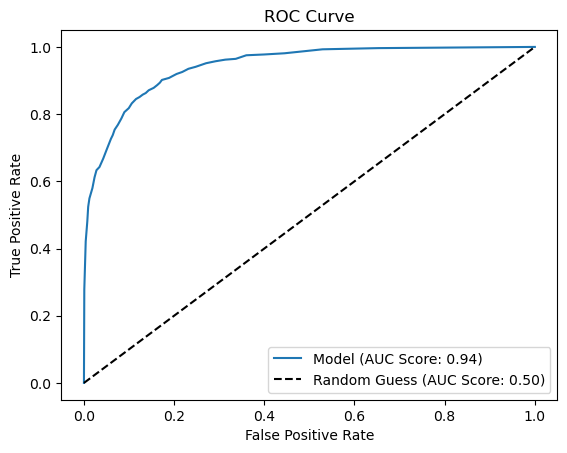

Accuracy Score: 0.866764705882353
Precision Score: 0.6852551984877127
Recall Score: 0.8579881656804734
f1 Score: 0.7619548081975828


<Figure size 640x480 with 0 Axes>

In [40]:
scoring(knn, X_val_std, y_val)

### Logistic Regression

In [41]:
params = {
    'C': np.linspace(0.01, 1, 100),
    'penalty': ['l1', 'l2'],
}

grid = GridSearchCV(
    LogisticRegression(solver='saga'), 
    params,
    scoring=make_scorer(f1_score),
    n_jobs=1,
    cv=5,
    verbose=1
)

grid.fit(X_train_std, y_train_rs)
grid.best_params_

lr = LogisticRegression(**grid.best_params_, solver='saga')
lr.fit(X_train_std, y_train_rs)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


LogisticRegression(C=0.01, penalty='l1', solver='saga')

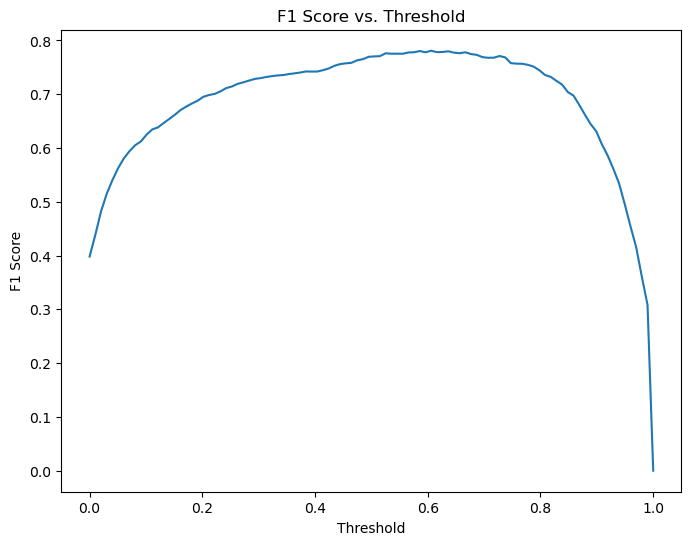

In [42]:
thresholds = np.linspace(0, 1, 100)
f1_scores = []
for threshold in thresholds:
    f1_scores.append(f1_score(y_val, lr.predict_proba(X_val_std)[:, 1] >= threshold))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()

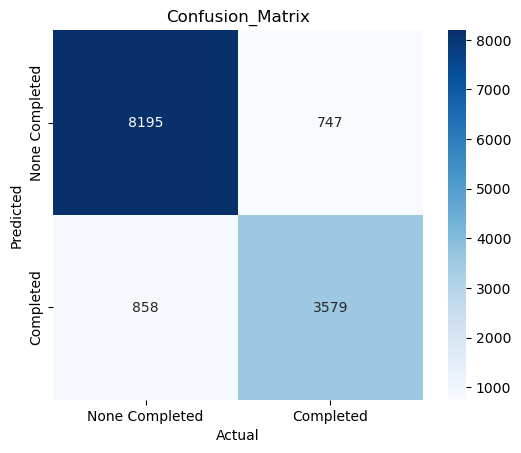

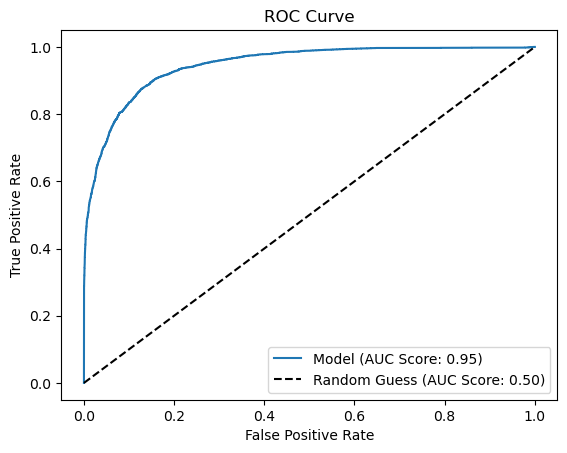

Accuracy Score: 0.8800358771208611
Precision Score: 0.8273231622746186
Recall Score: 0.8066260987153482
f1 Score: 0.8168435467305717


<Figure size 640x480 with 0 Axes>

In [43]:
scoring(lr, X_train_std, y_train_rs)

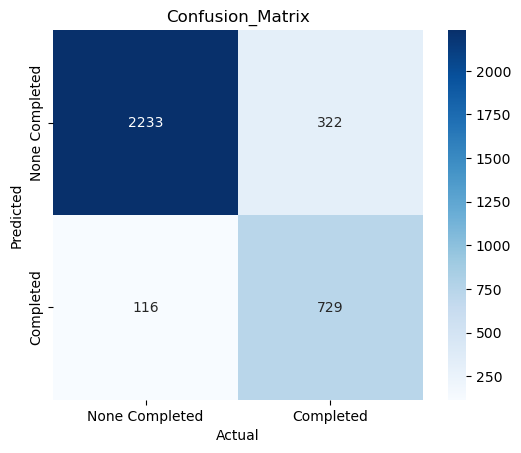

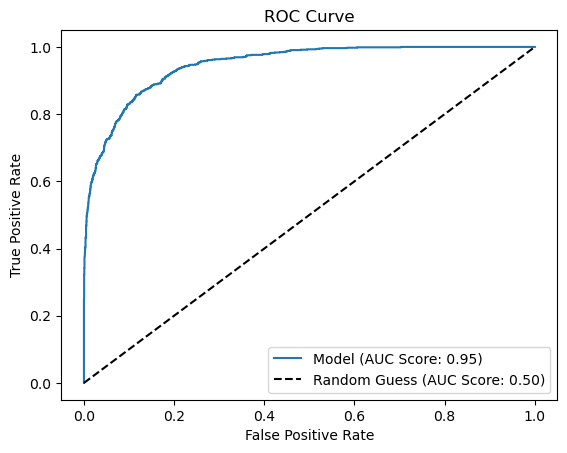

Accuracy Score: 0.8711764705882353
Precision Score: 0.6936251189343482
Recall Score: 0.8627218934911243
f1 Score: 0.7689873417721519


<Figure size 640x480 with 0 Axes>

In [44]:
scoring(lr, X_val_std, y_val)

In [45]:
pd.DataFrame(lr.coef_, columns=X_train.columns)

,gender_M,gender_Missing,gender_O,num_received,log_amount
0,0.0,0.0,0.0,-0.269937,-3.086791


### Random Forest

In [46]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

params = {
    'n_estimators': np.arange(100, 1100, 100),
    'max_features': [None, 'sqrt'],
    'bootstrap': [True],
    'max_samples': [None, 0.3, 0.5, 0.9],
    'max_depth': np.arange(1, 11),
    'min_samples_leaf': [2, 5, 10, 20, 100]
}

grid = RandomizedSearchCV(
    rf, 
    params,
    cv=3,
    scoring=make_scorer(f1_score),
    verbose=1
)
grid.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=42, **grid.best_params_)
rf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomForestClassifier(max_depth=6, max_features=None, min_samples_leaf=2,
                       n_estimators=700, random_state=42)

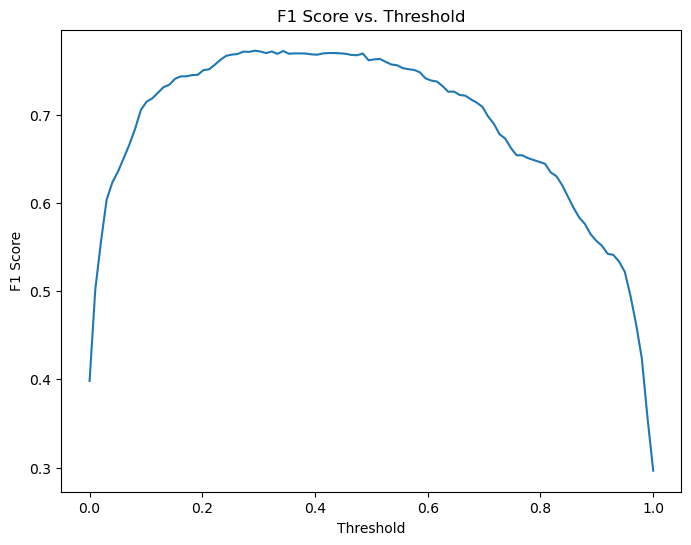

In [47]:
thresholds = np.linspace(0, 1, 100)
f1_scores = []
for threshold in thresholds:
    f1_scores.append(f1_score(y_val, rf.predict_proba(X_val)[:, 1] >= threshold))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()

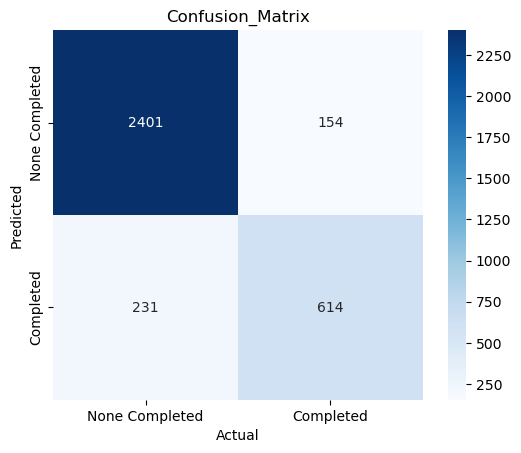

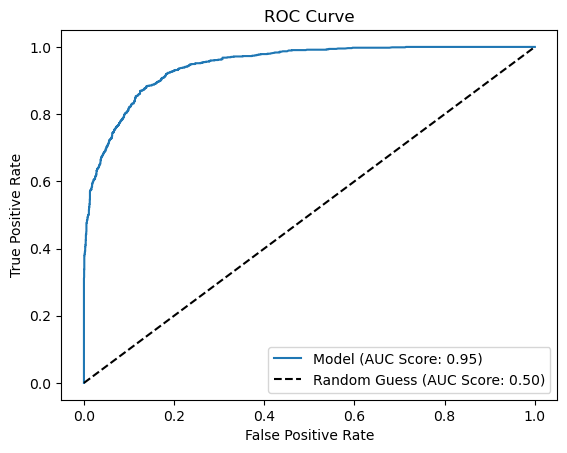

Accuracy Score: 0.8867647058823529
Precision Score: 0.7994791666666666
Recall Score: 0.7266272189349112
f1 Score: 0.7613143211407316


<Figure size 640x480 with 0 Axes>

In [48]:
scoring(rf, X_val, y_val)

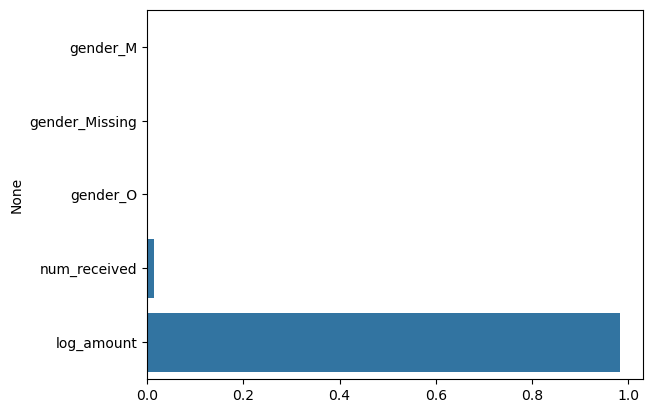

In [49]:
sns.barplot(
    x=rf.feature_importances_,
    y=X.columns
);